## 講習5 --- IRAF.APPHOTと結果の可視化

IRAFのapphotで点光源の測光をします。そしてその結果を可視化します。  

まず、IバンドのM15(5番フレーム)のフラット処理済みFITSファイルの一部分だけトリミングしておきます。   
この後の作業を少し楽にするためです。  

1500 x 1500 ピクセルの領域を下のように取り出し、iM15trim.fitsに書き出します。  
ヘッダのWCSの情報も、トリミングしたぶんだけシフトしておきます。  

In [4]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

In [3]:
hdu = fits.open('if0845t.fits')
imdata = hdu[0].data
hdu[0].data = imdata[1300:2800, 300:1800]
hdr = hdu[0].header
hdr['CRPIX1'] += -300
hdr['CRPIX2'] += -1220  # 本来、1300なのですが、ここで微調整しておきます
hdu.writeto('iM15n5trim.fits')
hdu.close()

### IRAF.APPHOT
まずは必要なモジュールをimportします。 そしてIRAFのパラメータを初期化しておきます。

In [5]:
from pyraf import iraf
from iraf import noao
from iraf import digiphot
from iraf import apphot

iraf.apphot.unlearn()
iraf.daofind.unlearn()
iraf.txdump.unlearn()

In [6]:
targetfits = 'iM15n5trim.fits'

星のfwhmを調べておきます。  

In [7]:
iraf.display(targetfits)

z1=3948.875 z2=4373.541


In [8]:
iraf.imexam()

#   COL    LINE   COORDINATES
#     R    MAG    FLUX     SKY    PEAK    E   PA BETA ENCLOSED   MOFFAT DIRECT
 679.12  696.47 679.12 696.47
   8.66  13.72  32520.   4079.   2781. 0.15  -22 9.47     2.91     2.97   2.89
 909.36  687.88 909.36 687.88
   8.73  12.46 103972.   4080.   8597. 0.00 INDEF 11.2     2.94     3.02   2.91
 990.05  868.48 990.05 868.48
   8.35  13.84  29232.   4061.   2404. 0.06  -35 3.34     2.76     2.80   2.79


星のfwhm = 3.0 pixelとしておきます。  

次に、バックグラウンドのmedianとノイズの評価をします。  

In [10]:
data = fits.getdata('iM15n5trim.fits')
np.median(data)

4077.4048

In [11]:
xx = np.where((data > 3000) & (data < 5000))
med = np.median(data[xx])
std = np.std(data[xx])

for i in range(5):
    xx = np.where((data > med - 3 * std) & (data < med + 3 * std))
    med = np.median(data[xx])
    std = np.std(data[xx])
    print ('{:.2f} {:.2f}'.format(med, std))  

4075.51 55.73
4074.68 50.54
4074.42 49.44
4074.35 49.18
4074.34 49.12


IRAFのタスクのパラメータを設定します。  

In [12]:
iraf.apphot.datapars.datamax = 34000   #   サチった星を入れない 
iraf.apphot.datapars.readnoise = 30
iraf.apphot.datapars.epadu = 5
iraf.apphot.datapars.itime = 20
iraf.apphot.fitskypars.dannulus = 5.
iraf.apphot.findpars.threshold = 10
iraf.apphot.findpars.sharphi = 0.8

iraf.apphot.daofind.output = 'ap.coo' # daofindの結果はこの名前のファイルに
iraf.apphot.daofind.interac = 'no'
iraf.apphot.daofind.verify = 'no'

iraf.apphot.phot.interactive = 'no'
iraf.apphot.phot.verify = 'no'
iraf.apphot.phot.verbose = 'no'
iraf.apphot.photpars.zmag = 27

ifwhm = 3
iraf.apphot.datapars.fwhmpsf = ifwhm
iraf.apphot.centerpars.cbox = max(5.0, ifwhm)
iraf.apphot.fitskypars.annulus = 3 * ifwhm
iraf.apphot.photpars.apertures = 3 * ifwhm

iraf.apphot.findpars.threshold = 10
iraf.apphot.datapars.sigma = std  
iraf.apphot.datapars.datamin = med - 5 * std  # 上で求めたmedとstd 

In [13]:
iraf.daofind(targetfits)
iraf.phot(targetfits, coords='ap.coo', output='ap.mag')  # apphotの結果をファイル'ap.mag'に
mlim = 0.15  # merr < 0.15 のものだけ
iraf.txdump('ap.mag', fields='xc,yc,mag,merr', expr='cier == 0 && merr<'+str(mlim), Stdout='coo.txt')  
# 'ap.mag'の中から必要な項目だけを抽出してファイル'coo.txt'に

In [14]:
# cat 'coo.txt'    #   githubで長くなるのでコメントアウト

まだ instrumental magnitudeですが、光度関数とmag vs. merrプロットを描いてみます。  
numpyのところでやったように、**numpy.loadtxt()**を使ってcoo.txtからデータを読み込みます。

In [15]:
xymag = np.loadtxt('coo.txt')

pythonのインデックスは0から始まることに注意。等級は3カラム目。等級エラーは4カラム目。

In [16]:
mag = xymag[:, 2]
merr = xymag[:, 3]

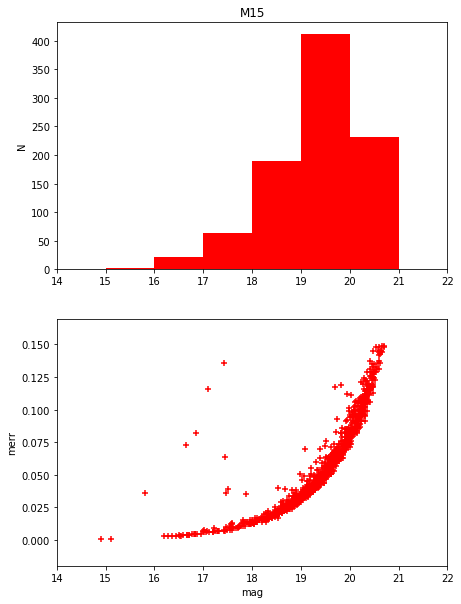

In [17]:
plt.figure(figsize=(7, 10))

plt.subplot(211)
plt.hist(mag, bins=8, range=(14,22), color='red')
plt.xlim(14, 22)
plt.title('M15')
plt.ylabel('N')

plt.subplot(212)
plt.scatter(mag, merr, marker='+', color='red')
plt.xlim(14, 22)
plt.xlabel('mag')
plt.ylabel('merr')
plt.show()

FITS画像を表示して、測光した星にマークをつけます。  
FITS画像のデータをpyfitsで読み込む時、各ピクセルのインデックスは0から始まります。IRAFのAPPHOTで得られる(x, y)=(1,1)はPYTHONの配列では(0,0)です。 したがって、マークをつける場合には1だけ引いてやる必要があります。

In [18]:
xcoo = xymag[:, 0] - 1
ycoo = xymag[:, 1] - 1

In [19]:
imdata = fits.getdata(targetfits)

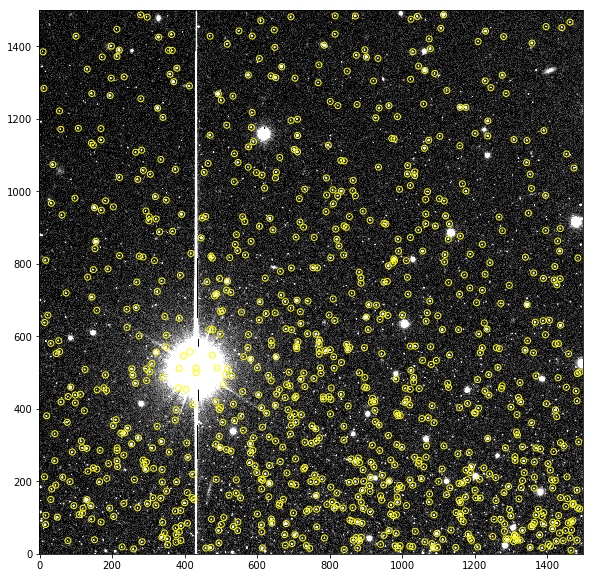

In [31]:
plt.figure(figsize=(10, 10))
plt.imshow(imdata, plt.cm.gray, vmin=med - std, vmax = med + 7 * std, origin='lower', interpolation='none')
plt.scatter(xcoo, ycoo, edgecolors='yellow', facecolors='none')
plt.show()

**[小技]**  
適当にスケーリングして、明るさに応じて円の大きさを変えてみます。

In [28]:
plotsize = pow(10, -0.4 * mag) * 1.0e8 * 5

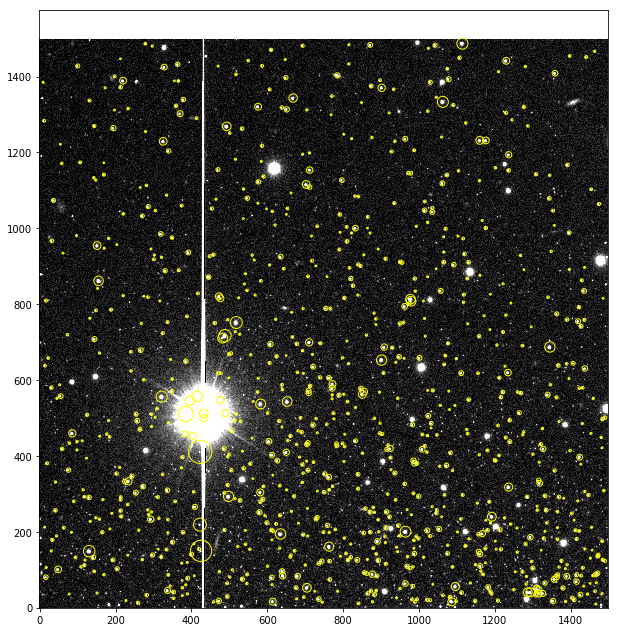

In [33]:
plt.figure(figsize=(11, 11))
plt.imshow(imdata, plt.cm.gray, vmin=med - std, vmax = med + 10 * std, origin='lower', interpolation='none')
plt.scatter(xcoo, ycoo, s=plotsize, edgecolors='yellow', facecolors='none')
plt.show()

### 明るさの較正  

標準星の観測フレームがあれば、標準星についてもアパーチャ測光を行い、等級のゼロ点を求めます。  
ですが、ここでは、SDSSのカタログを使って較正を行います。  

Yagi et al. (2012)によると、  
i (SDSS - SC) = -0.005 + 0.087 * (r-i)(SDSS)   
のシステム変換が示されています。両者のiバンドの差は、SDSSの (r-i)に緩く依存します。  
SDSSカタログを使って、Suprime Camのiバンドの較正ができそうです。

この視野に写っているSDSSの星と今回の測光を比較して、等級のゼロ点補正を行います。  


#### カタログのダウンロード  

1. ds9でiM15n5trim.fitsをオープンします。  
2. Analysis > Catalogs > Optical > SDSS Release7 をえらびます  
するとSDSSの星がプロットされます。少しずれてますね。 望遠鏡のポインティングは完璧ではありません。  
3. SDSS Release7のWindowのFile > Export > Tab-Separated-Value でtsvファイルにSDSSカタログのこの画面のものを書き出します。　  
ここでは、m15sdss.tsv と名前をつけておきます。  



In [38]:
sdssdata = np.genfromtxt('m15sdss.tsv', delimiter='\t', usecols=(0,1,3,11,12,13,14), skip_header=1)

今回のファイルには、数値以外の値もふくまれています。そのようなとき、np.loadtxt()は使えません。  
np.genfromtxt()を使います。  

In [47]:
sdssdata[:5]

array([[  3.22456710e+02,   1.22811830e+01,   6.00000000e+00,
          2.08780000e+01,   4.70000000e-02,   2.08740000e+01,
          7.90000000e-02],
       [  3.22456891e+02,   1.22885970e+01,   6.00000000e+00,
          2.17270000e+01,   1.02000000e-01,   2.14750000e+01,
          1.41000000e-01],
       [  3.22456987e+02,   1.22854300e+01,   6.00000000e+00,
          2.01100000e+01,   2.60000000e-02,   1.99690000e+01,
          3.70000000e-02],
       [  3.22457067e+02,   1.22916460e+01,   6.00000000e+00,
          1.97290000e+01,   1.90000000e-02,   1.96270000e+01,
          2.80000000e-02],
       [  3.22457421e+02,   1.22938290e+01,   6.00000000e+00,
          2.34590000e+01,   4.22000000e-01,   2.17060000e+01,
          1.65000000e-01]])

RA, Dec, Class, Rmag, Rerr, Imag, Ierrの順で各列にデータが入りました。  
Classは星とか銀河とかのタイプを表しています。ここでは、6の星の行だけを抜き出します。  
さらに、この視野外の星も含まれています。 それらを削除します。(このあとのccxymatchで重要)  

In [50]:
stardata = sdssdata[ np.where(  (sdssdata[:, 2]==6) & (sdssdata[:, 0] > 322.4743) &  (sdssdata[:, 0] < 322.5604) \
                              & (sdssdata[:, 1] > 12.2418) & (sdssdata[:, 1] < 12.3259)  ) ]

長いコマンドを途中で改行するために、 \ を使いました。

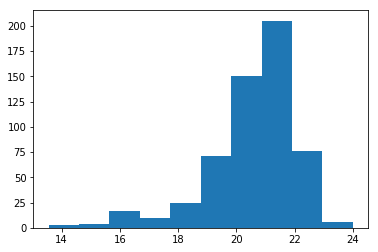

In [52]:
plt.hist(stardata[:, 5])
plt.show()

SDSSカタログと今回の測光結果のマッチングを行うのですが、等級の範囲をそろえておきます。  

In [53]:
xybright = xymag[np.where((xymag[:, 2] < 18) & (xymag[:, 2] > 16))]  

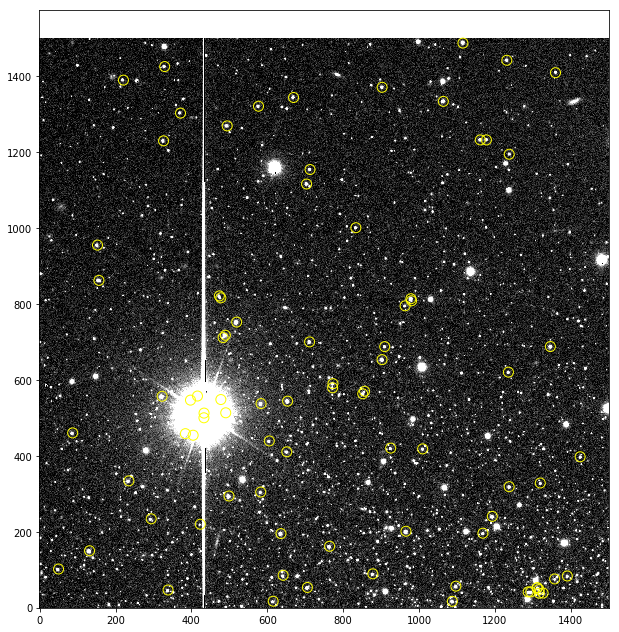

In [54]:
plt.figure(figsize=(11, 11))
plt.imshow(imdata, plt.cm.gray, vmin=med - std, vmax = med + 7 * std, origin='lower', interpolation='none')
plt.scatter(xybright[:, 0], xybright[:, 1], edgecolors='yellow', facecolor='none', s=100)
plt.show()

In [55]:
import warnings
warnings.filterwarnings('ignore')
import aplpy

In [56]:
sdssbright = stardata[np.where((stardata[:, 5] < 19) & (stardata[:, 5] > 16))]

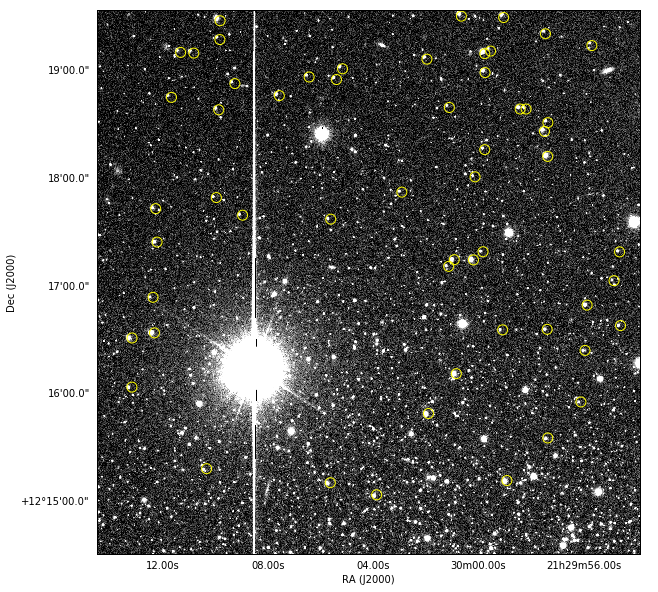

In [57]:
figure = aplpy.FITSFigure('iM15n5trim.fits', figsize=(10, 10))
figure.show_markers(sdssbright[:, 0], sdssbright[:, 1], edgecolor='yellow', s=100)  #   sで円の面積を指定
figure.show_grayscale(vmin = med - std, vmax = med + 5 * std)

同じくらいの星の数ですね。  
それでは、これらをテキストファイルに書き出します。  

In [58]:
np.savetxt('brightxy.txt', xybright, fmt='%f')
np.savetxt('brightsdss.txt', sdssbright, fmt='%f') 

#### IRAF.CCXYMATCH  
パラメータを設定します。  

In [59]:
iraf.ccxymatch.unlearn()

In [60]:
iraf.ccxymatch.ptolerance = 10
iraf.ccxymatch.xin = 750
iraf.ccxymatch.yin = 750
iraf.ccxymatch.xmag = 0.2
iraf.ccxymatch.ymag = 0.2
iraf.ccxymatch.xrot = 180
iraf.ccxymatch.yrot = 0
iraf.ccxymatch.lngref = 322.5174
iraf.ccxymatch.latref = 12.2838
iraf.ccxymatch.lngunits = 'degrees' 
iraf.ccxymatch.latunits = 'degrees'
iraf.ccxymatch.lngformat = '%13.7g'
iraf.ccxymatch.latformat = '%13.7g'

In [61]:
iraf.ccxymatch.nmatch = 60

In [62]:
iraf.ccxymatch('brightxy.txt', 'brightsdss.txt', 'match.coo')


Input: brightxy.txt  Reference: brightsdss.txt  Number of tie points: 0
Initial linear transformation
      xi[tie] =       150. +       -0.2 * x[tie] +         0. * y[tie]
     eta[tie] =      -150. + 3.01992E-8 * x[tie] +        0.2 * y[tie]
    dx: 150.00 dy: -150.00 xmag: 0.200 ymag: 0.200 xrot: 180.0 yrot: 0.0

Matched triangles transformation
      xi[tie] =   149.4436 + -0.2014859 * x[tie] + -1.1350E-4 * y[tie]
     eta[tie] =  -150.9064 + -6.6720E-5 * x[tie] +  0.2008613 * y[tie]
    dx: 149.44 dy: -150.91 xmag: 0.201 ymag: 0.201 xrot: 180.0 yrot: 0.0

26 reference coordinates matched


これで二つのテーブルのマッチングができました。 

In [63]:
cat match.coo


# Input: brightxy.txt  Reference: brightsdss.txt  Number of tie points: 0
# Initial linear transformation
#       xi[tie] =       150. +       -0.2 * x[tie] +         0. * y[tie]
#      eta[tie] =      -150. + 3.01992E-8 * x[tie] +        0.2 * y[tie]
# dx: 150.00 dy: -150.00 xmag: 0.200 ymag: 0.200 xrot: 180.0 yrot: 0.0
#
# Matched triangles transformation
#       xi[tie] =   149.4436 + -0.2014859 * x[tie] + -1.1350E-4 * y[tie]
#      eta[tie] =  -150.9064 + -6.6720E-5 * x[tie] +  0.2008613 * y[tie]
# dx: 149.44 dy: -150.91 xmag: 0.201 ymag: 0.201 xrot: 180.0 yrot: 0.0
#
# Column definitions
#    Column 1: Reference Ra / Longitude coordinate
#    Column 2: Reference Dec / Latitude coordinate
#    Column 3: Input X coordinate
#    Column 4: Input Y coordinate
#    Column 5: Reference line number
#    Column 6: Input line number

     322.5161      12.25088        764.187       161.723     34    19
     322.5234      12.25276        636.042       195.125     38    20
      322.543     

一番右の二つのカラムが、入力したファイルの何行目と何行目の星が同じかを表しています。  
ですので、その情報をもとに等級を比較しましょう。  

In [64]:
bxycoo = np.loadtxt('brightxy.txt')
bradeccoo = np.loadtxt('brightsdss.txt')

In [65]:
match_id = []
with open('match.coo') as f:
    for line in f:
        item = line.rstrip()
        if len(item) > 0 and line[0]  != '#':
            v = item.split()
            match_id.append((int(v[4]), int(v[5])))

In [67]:
rmag = []
imag = []
magme = []
for item in match_id:
    id1 = item[0] - 1
    id2 = item[1] - 1
    rmag.append(bradeccoo[id1][3])
    imag.append(bradeccoo[id1][5])
    magme.append(bxycoo[id2][2])

imag = np.array(imag)
rmag =  np.array(rmag)
magme = np.array(magme)

システム変換を考えずに、i(SDSS) vs. inst.mag - SDSS をプロットします。 

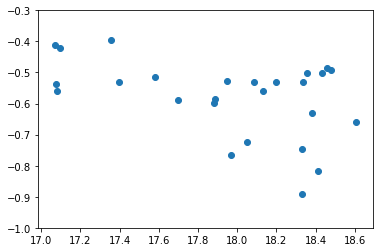

In [76]:
plt.scatter(imag, magme - imag)
plt.ylim(-1.0, -0.3)
plt.show()

右側でばらつきが大きいです。  

次に、(r - i)SDSS vs. inst.mag - SDSS をプロットします。  

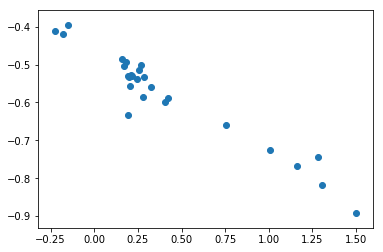

In [69]:
plt.scatter(rmag - imag, magme - imag)
plt.show()

上で見たばらつきは、システム変換で説明できそうです。  
ただし、Yagi et al. (2012)の i (SDSS - SC) = -0.005 + 0.087 * (r-i)(SDSS)   
よりも勾配は急に見えます。  


In [82]:
from scipy import stats

In [80]:
x = rmag - imag
y =  magme - imag

In [85]:
stats.linregress(x, y)

LinregressResult(slope=-0.25624492235987911, intercept=-0.47337948763154197, rvalue=-0.9659328677143425, pvalue=1.3552658697350719e-15, stderr=0.014013765105769863)

勾配は-0.26ですね。ここでは、システム変換をせずに、カラーが0のときのゼロ点補正だけをしておきましょう。  
inst.mag - SDSS = -0.47 なので inst.magに+0.47すればよいです。  

In [88]:
xymag[:, 2] = xymag[:, 2] + 0.47

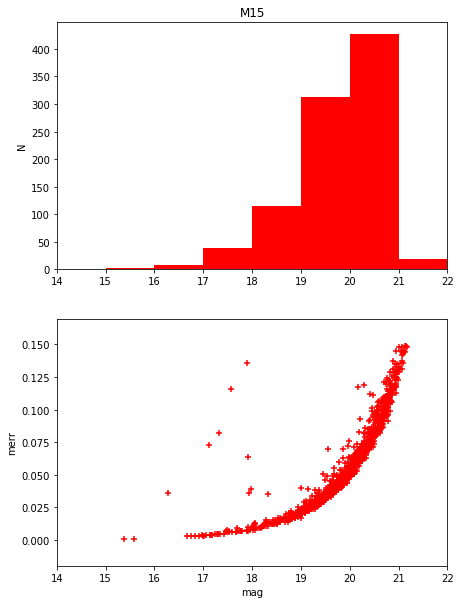

In [89]:
mag = xymag[:, 2]
merr = xymag[:, 3]

plt.figure(figsize=(7, 10))

plt.subplot(211)
plt.hist(mag, bins=8, range=(14,22), color='red')
plt.xlim(14, 22)
plt.title('M15')
plt.ylabel('N')

plt.subplot(212)
plt.scatter(mag, merr, marker='+', color='red')
plt.xlim(14, 22)
plt.xlabel('mag')
plt.ylabel('merr')
plt.show()

### このマッチング本当かな〜？　　
FITSヘッダにそのマッチングから計算したwcsを埋め込み、ds9で表示させ、SDSSの星をオーバープロットしてみます。  
念のために、違う名前のファイルをコピーして作成し、そこにwcsを埋め込みます。


In [90]:
cp iM15n5trim.fits iM15wcs.fits

In [100]:
iraf.ccmap.unlearn()

iraf.ccmap.xcolumn = 3
iraf.ccmap.ycolumn = 4
iraf.ccmap.lngcolumn = 1
iraf.ccmap.latcolumn = 2
iraf.ccmap.lngunits = 'degrees'
iraf.ccmap.latunits = 'degrees'
iraf.ccmap.maxiter = 1
iraf.ccmap.verbose = 'yes'
iraf.ccmap.interactive = 'no'

In [101]:
iraf.ccmap('match.coo', 'ccmap.db')

Refsystem: j2000  Coordinates: equatorial FK5
    Equinox: J2000.000 Epoch: J2000.00000000 MJD: 51544.50000
Insystem: j2000  Coordinates: equatorial FK5
    Equinox: J2000.000 Epoch: J2000.00000000 MJD: 51544.50000

Coords File: match.coo  Image: 
    Database: ccmap.db  Solution: match.coo
Coordinate mapping status
    XI fit ok.  ETA fit ok.
    Ra/Dec or Long/Lat fit rms: 0.106  0.0808   (arcsec  arcsec)
Coordinate mapping parameters
    Sky projection geometry: tan
    Reference point: 322:30:57.27  12:17:53.70  (degrees  degrees)
    Reference point: 767.278  1010.984  (pixels  pixels)
    X and Y scale: 0.201  0.201  (arcsec/pixel  arcsec/pixel)
    X and Y axis rotation: 179.982  359.984  (degrees  degrees)


In [102]:
iraf.ccsetwcs('iM15wcs.fits', 'ccmap.db', 'match.coo')

Image: iM15wcs.fits  Database: ccmap.db  Solution: match.coo
Coordinate mapping parameters
    Sky projection geometry: tan
    Reference point: 322:30:57.27  12:17:53.70  (degrees   degrees)
    Ra/Dec logical image axes: 1  2
    Reference point: 767.278  1010.984  (pixels  pixels)
    X and Y scale: 0.201  0.201  (arcsec/pixel  arcsec/pixel)
    X and Y coordinate rotation: 179.982  359.984  (degrees  degrees)
Updating image header wcs


m15wcs.fitsを表示させて、SDSSカタログをオーバープロットさせてみましょう。  
大丈夫ですね。これで、より正しいwcsの埋め込まれたFITSファイルができました。  